This notebook is the implementation of the Recurrent Neural Network for stock prediction. We use Tushare API for scraping and developing our dataset. To make the training process easier and shorter. We chose to train on a single stock dataset 000001.SZ, which holds about 3000 days of stock data from January 1st, 2010 to December 31th, 2022. The Ann is consist of 2 parts: the encoder and decoder layer. The encoder has 1 LSTM layer
2 attention layer, the decoder has 1 attention layer, 1 LSTM layer and 2 full connection layer.  We removed some attention layer comparing to  the standard ANN model. There are the specific reasons:

1) our dataset is kind of a small dataset, which will not fit in a too big neural network 2) Adding too many attention layer won't make the performance better, since the parameter of each layer may be underrfitting, if too many layers, the error accumulation of each layer will obviously cause a underfitting.

The encoder layer has a LSTM layer whose input dimension is 10 and hidden size of 64 due to the way that we preprocessing our dataset. The attention layer in encoder has dimension 128  ×  1.
In the decoder layer, firstly, the data would pass by a linear layer, whose size is 128*1, then there is full connection layer1 has dimension 65 ×  1. And then data would pass a LSTM layer whose input dimension is 1 and hidden size of 64. Final the data would be a one-size output through the full connection layer2 whose size is 128  ×  1.

In [125]:
!pip install tushare

Import data API

In [126]:
import tushare as ts
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import math
import time
#import utils

Use set_token() to obtain the data token.

In [127]:
ts.set_token('293d683e83b36fad82472d9a4b4c3903d21fa6bcb85cb0cd4f4b9414')

ts_code represents the stock code, people could change it to convert to any other stock.<br>
open represents the opening price. <br>
high represents the highest price in a day. <br>
low represents the lowest price in a day. <br>
close represents the closed price in a day. <br>
pre_close represents the pre_closed price in a day. <br>
change represents the rise and decline in a day.<br>
pct_chg represents the precents of the change in a day.<br>
vol represents the trading volume. <br>
amount represents the transaction volume.

In [128]:
pro = ts.pro_api()
df = pro.daily(ts_code='000001.SZ', start_date='2010-01-01', end_date='2022-12-31')[0:2500]
df_1 = pro.daily(ts_code='000001.SZ', start_date='2010-01-01', end_date='2022-12-31')[0:2500]
df['Date'] = df['trade_date']
df['Close'] = df['close']
df_1['Date'] = df_1['trade_date']
df_1['Close'] = df_1['close']
df.to_csv('./600600.csv')
df_1.to_csv('./600612.csv')
df.head(-1)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,Date,Close
0,000001.SZ,20211118,18.09,18.12,17.73,17.80,18.11,-0.31,-1.7118,799843.77,1.430058e+06,20211118,17.80
1,000001.SZ,20211117,18.15,18.30,17.98,18.11,18.22,-0.11,-0.6037,664640.38,1.203859e+06,20211117,18.11
2,000001.SZ,20211116,18.36,18.54,18.17,18.22,18.43,-0.21,-1.1394,601110.48,1.099113e+06,20211116,18.22
3,000001.SZ,20211115,18.35,18.63,18.20,18.43,18.27,0.16,0.8758,655089.99,1.203764e+06,20211115,18.43
4,000001.SZ,20211112,18.31,18.63,18.11,18.27,18.35,-0.08,-0.4360,957546.46,1.753073e+06,20211112,18.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,000001.SZ,20110722,17.25,17.45,17.15,17.21,17.18,0.03,0.1700,122733.19,2.118701e+05,20110722,17.21
2495,000001.SZ,20110721,17.52,17.56,17.17,17.18,17.54,-0.36,-2.0500,188971.22,3.269483e+05,20110721,17.18
2496,000001.SZ,20110720,17.69,17.74,17.38,17.54,17.54,0.00,0.0000,145934.99,2.555163e+05,20110720,17.54
2497,000001.SZ,20110719,17.75,17.76,17.48,17.54,17.94,-0.40,-2.2300,219355.26,3.856451e+05,20110719,17.54


Initialize the encoder and decoder layers:<br>
The input sequence is transformed into a fixed length vector in the encoder layer, and then the previously generated vector is transformed into an output sequence in the decoder layer.<br>
In this case, we have 2 same stocks, the first one is the driving stock, we use it to train, and the second one is the target stock, we use it to be the label.<br>
The encoder layer has:<br>
1 LSTM layer<br>
2 attention layer<br>

The decoder layer has:<br>
1 attention layer<br>
1 LSTM layer<br>
2 full connection layer<br>
We also tried dropout  method. The dropout layer will randomly deactivate some neurons with 0.8 possibility, since we have relatively small dataset, adding on dropout layer is a good choice.<br>
Since the data we have is a relevant small data sets, so we add fewer attention layers than that of other models.

In [129]:
import torch
from torch import nn
import torch.nn.functional as F

ENCODER_HIDDEN_SIZE = 64
DECODER_HIDDEN_SIZE = 64
data = './600600.csv'
t = './600612.csv'

class AttnEncoder(nn.Module):

    def __init__(self, input_size, hidden_size, time_step):
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.t_stp = time_step
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1,dropout=0.8)
        self.attn1 = nn.Linear(in_features=2 * hidden_size, out_features=1)

    def forward(self, driving_x):
        batch_size = driving_x.size(0)
        # size: batch_size * time_step * hidden_size
        code = torch.zeros(batch_size, self.t_stp, self.hidden_size)
        # Initialize hidden state
        h = self.init_variable(1, batch_size, self.hidden_size)
        # Initialize LSTM cell status
        s = self.init_variable(1, batch_size, self.hidden_size)
        for t in range(self.t_stp):
            # batch_size * input_size * (2 * hidden_size + time_step)
            x = torch.cat((self.embedding_hidden(h), self.embedding_hidden(s)), 2)
            z1 = self.attn1(x)
            if batch_size > 1:
                attn_w = F.softmax(z1.view(batch_size, self.input_size), dim=1)
            else:
                attn_w = self.init_variable(batch_size, self.input_size) + 1
            # batch_size * input_size
            weighted_x = torch.mul(attn_w, driving_x[:, t, :])
            _, states = self.lstm(weighted_x.unsqueeze(0), (h, s))
            h = states[0]
            s = states[1]
            code[:, t, :] = h

        return code
    def init_variable(self, *args):
        zero_tensor = torch.zeros(args)
        if torch.cuda.is_available():
            zero_tensor = zero_tensor.cuda()
        return torch.tensor(zero_tensor)

    def embedding_hidden(self, x):
        return x.repeat(self.input_size, 1, 1).permute(1, 0, 2)
class AttnDecoder(nn.Module):

    def __init__(self, code_hidden_size, hidden_size, time_step):
        super(AttnDecoder, self).__init__()
        self.code_hidden_size = code_hidden_size
        self.hidden_size = hidden_size
        self.t_stp = time_step
        print('the code_hidden_size:',code_hidden_size)
        print('the hidden_size:',hidden_size)
        self.attn1 = nn.Linear(in_features=2 * hidden_size, out_features=1)
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size,dropout=0.8)
        self.fc1 = nn.Linear(in_features=self.code_hidden_size + 1, out_features=1)
        self.fc2 = nn.Linear(in_features=code_hidden_size + hidden_size, out_features=1)

    def forward(self, h, y_seq):
        batch_size = h.size(0)
        d = torch.zeros(1, batch_size, self.hidden_size)
        s = torch.zeros(1, batch_size, self.hidden_size)
        ct = torch.zeros(batch_size, self.hidden_size)

        for t in range(self.t_stp):
            # batch_size * time_step * (encoder_hidden_size + decoder_hidden_size)
            x = torch.cat((self.embedding_hidden(d), self.embedding_hidden(s)), 2)
            z1 = self.attn1(x)
            if batch_size > 1:
                beta_t = F.softmax(z1.view(batch_size, -1), dim=1)
            else:
                beta_t = self.init_variable(batch_size, self.code_hidden_size) + 1
            # batch_size * encoder_hidden_size
            ct = torch.bmm(beta_t.unsqueeze(1), h).squeeze(1)
            if t < self.t_stp - 1:
                yc = torch.cat((y_seq[:, t].unsqueeze(1), ct), dim=1)
                y_fc1 = self.fc1(yc)
                _, states = self.lstm(y_fc1.unsqueeze(0), (d, s))
                d = states[0]
                s = states[1]
        # batch_size * 1
        y_res = self.fc2(torch.cat((d.squeeze(0), ct), dim=1))
        return y_res

    def init_variable(self, *args):
        zero_tensor = torch.zeros(args)
        if torch.cuda.is_available():
            zero_tensor = zero_tensor.cuda()
        return torch.tensorn(zero_tensor)

    def embedding_hidden(self, x):
        return x.repeat(self.t_stp, 1, 1).permute(1, 0, 2)

Split the dataset and do the normalization.<br>
Only use the data of the closing price field in the data, but can also be tested more price fields, for example, volume and opening price

Prepare X and y data, similar to the previous, first use the closing price of the most recent trading day as the first y, and then the closing price of the 10 trading days before this trading day as X. For example, the second most recent closing price is the second y, and the closing price of 10 trading days before the latest second closing price is used as the second X, and so on.

In [130]:
import numpy as np
import pandas as pd
import math

class Dataset:

    def __init__(self, driving_csv, target_csv, T, split_ratio=0.8, normalized=True):
        stock_frame1 = pd.read_csv(driving_csv)
        stock_frame2 = pd.read_csv(target_csv)
        if stock_frame1.shape[0] > stock_frame2.shape[0]:
            
            stock_frame1 = stock_frame1[stock_frame1.loc[stock_frame1['Date'] == stock_frame2['Date'][0]].index[0]:].reset_index()
            
        else:           
            stock_frame2 = stock_frame2[stock_frame2.loc[stock_frame2['Date'] ==  stock_frame1['Date'][0]].index[0]:].reset_index()

        stock_frame1 = stock_frame1['Close'].fillna(method='pad')
        stock_frame2 = stock_frame2['Close'].fillna(method='pad')
        self.train_size = int(split_ratio * (stock_frame2.shape[0] - 2*T - 1))
        self.test_size = stock_frame2.shape[0] - 2*T  - 1 - self.train_size 
        ts_x, ts_y, ts_y_seq = [], [], []
        for i in range(len(stock_frame1) - 2*T - 1):
            last = i + T
            ts_x.append(stock_frame1[i: last])
            ts_y.append(stock_frame2[last])
            ts_y_seq.append(stock_frame2[i: last])    
        self.X = np.array(ts_x)
        self.y = np.array(ts_y)
        self.y_seq = np.array(ts_y_seq)
        if normalized:
            sc = StandardScaler()
            self.X = sc.fit_transform(self.X)
            self.y_seq = sc.fit_transform(self.y_seq)        

Function to evaluate the network on the test set 

In [131]:
def predict( x, y, y_seq, batch_size):
        driving = data
        time_step = batch_size
        target = t   
        dataset = Dataset(driving, target, time_step, split)
        y_pred = np.zeros(x.shape[0])
        i = 0
        while (i < x.shape[0]-1):
            batch_end = i + batch_size
            if batch_end > x.shape[0]:
                batch_end = x.shape[0]
            var_x_input =  torch.from_numpy(x[i: batch_end]).float()
            var_y_input = torch.from_numpy(y_seq[i: batch_end]).float()
            if var_x_input.dim() == 2:
                var_x_input = var_x_input.unsqueeze(2)
            code = trainer.encoder(var_x_input)
            y_res = trainer.decoder(code, var_y_input)
            loss = nn.MSELoss()(y_res, var_y_input) 
            for j in range(i, batch_end):
                y_pred[j] = y_res[j - i, -1]
            i = batch_end
        return y_pred 

       

Do 20 passes through the training set. Divide the learning rate by 2 every 5 epoch.<br>
We count the loss for each epoch and sum it up to check the final total loss. During the whole building process, we tried different criterions such as Adam, Adamw and SDG. AdamW and Adam can converge in a relatively short time, but the model does not generalize well on our test data. after several choice, we figured out that SDG is our best choice.<br>
We save the model in the final, since the training process is random, so we provide the best model in our training model, and the correponding storage path needs to be adjusted by users themselves.

In [132]:
import argparse
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import optim


class Trainer:

    def __init__(self, driving, target, time_step, split, lr):
        self.dataset = Dataset(driving, target, time_step, split)
        self.encoder = AttnEncoder(input_size=self.dataset.X.shape[1], hidden_size=ENCODER_HIDDEN_SIZE, time_step=time_step)
        self.decoder = AttnDecoder(code_hidden_size=ENCODER_HIDDEN_SIZE, hidden_size=DECODER_HIDDEN_SIZE, time_step=time_step)
        self.encoder.attn1.weight.data.uniform_(-0.1, 0.1)
        self.decoder.attn1.weight.data.uniform_(-0.1, 0.1)
        self.decoder.fc1.weight.data.uniform_(-0.1, 0.1)   
        self.decoder.fc2.weight.data.uniform_(-0.1, 0.1)           
        self.lr = lr
        self.encoder_optim = optim.SGD(self.encoder.parameters(), lr,momentum=0.5)
        self.decoder_optim = optim.SGD(self.decoder.parameters(), lr,momentum=0.5)
        self.loss_func = nn.MSELoss()
        self.train_size =  self.dataset.train_size
        self.test_size = self.dataset.test_size


    def train_minibatch(self, num_epochs, batch_size, interval):
        n = 1
        for epoch in range(num_epochs):
            i = 0
            if n % 5 == 0:
                self.lr = self.lr/2
            loss_sum = 0
            self.encoder_optim = optim.SGD(self.encoder.parameters(), lr=self.lr)
            self.decoder_optim = optim.SGD(self.decoder.parameters(), lr=self.lr)
            while (i < self.train_size-1):
                
                self.encoder_optim.zero_grad()
                self.decoder_optim.zero_grad()
                batch_end = i + batch_size
                if (batch_end >= self.train_size):
                    batch_end = self.train_size
                var_x = torch.tensor(torch.from_numpy(self.dataset.X[:self.train_size][i: batch_end]).float())
                var_y= torch.tensor(torch.from_numpy(self.dataset.y[:self.train_size][i: batch_end]).float())
                var_y_seq = torch.tensor(torch.from_numpy(self.dataset.y_seq[:self.train_size][i: batch_end]).float())
                if var_x.dim() == 2:
                    var_x = var_x.unsqueeze(2)
                code = self.encoder(var_x)
                y_res = self.decoder(code, var_y_seq)
                loss = self.loss_func(y_res, var_y)
                loss.backward()
                self.encoder_optim.step()
                self.decoder_optim.step()
                loss_sum += loss.item()
                i = batch_end
            n += 1
            print('epoch [%d] finished, the average loss is %f, the learning_rate is %f' % (epoch, loss_sum/n, self.lr))
            if (epoch + 1) % (interval) == 0 or epoch + 1 == num_epochs:
               # print(self.encoder.state_dict())
                torch.save(self.encoder.state_dict(), r'./' + str(epoch + 1) + '-norm' + '.model')
                torch.save(self.decoder.state_dict(), r'./' + str(epoch + 1) + '-norm' + '.model')



    def load_model(self, encoder_path, decoder_path):
        self.encoder.load_state_dict(torch.load(encoder_path, map_location=lambda storage, loc: storage))
        self.decoder.load_state_dict(torch.load(decoder_path, map_location=lambda storage, loc: storage))


Initialize the network parameters.

In [133]:
num_epochs = 20
batch_size = 10
split = 0.9
interval = 1
lr = 0.05
test = False
mname = ''
trainer = Trainer(data, t, 10, split, lr)

the code_hidden_size: 64
the hidden_size: 64


/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Do the training on the training set.

In [134]:
trainer.train_minibatch(num_epochs, batch_size, interval)

/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/ipykernel_launcher.py:

epoch [0] finished, the average loss is 751.040586, the learning_rate is 0.050000
epoch [1] finished, the average loss is 129.627838, the learning_rate is 0.050000
epoch [2] finished, the average loss is 94.263690, the learning_rate is 0.050000
epoch [3] finished, the average loss is 50.420821, the learning_rate is 0.050000
epoch [4] finished, the average loss is 28.256913, the learning_rate is 0.025000
epoch [5] finished, the average loss is 18.580601, the learning_rate is 0.025000
epoch [6] finished, the average loss is 15.724433, the learning_rate is 0.025000
epoch [7] finished, the average loss is 13.777488, the learning_rate is 0.025000
epoch [8] finished, the average loss is 12.292827, the learning_rate is 0.025000
epoch [9] finished, the average loss is 11.439178, the learning_rate is 0.012500
epoch [10] finished, the average loss is 9.872910, the learning_rate is 0.012500
epoch [11] finished, the average loss is 8.964632, the learning_rate is 0.012500
epoch [12] finished, the a

Make prediction on the test set. Note that the model loaded here is obtained from the model saved above in the training process.<br>

In [135]:
sc = StandardScaler()
def eval_on_the_test(num_epochs,batch_size):
    trainer.load_model(r'./encoder40-norm' + mname + '.model', r'./decoder40-norm' + mname + '.model')
    driving = data
    time_step = batch_size
    target = t
    dataset = Dataset(driving, target, time_step, split)
    x_train = dataset.X[:dataset.train_size]
    y_train = dataset.y[:dataset.train_size]
    y_seq_train = dataset.y_seq[:dataset.train_size]
    x_test = dataset.X[dataset.train_size:]
    y_test = dataset.y[dataset.train_size:]
    y_seq_test = dataset.y_seq[dataset.train_size:]   

    y_pred_train = predict(x_train, y_train, y_seq_train, batch_size)
    y_pred_test = predict(x_test, y_test, y_seq_test, batch_size)
    predict_1 = y_pred_test
    truth = y_test
    plt.figure(figsize=(8,6), dpi=100)
    plt.plot(range(2000, dataset.train_size), dataset.y[:dataset.train_size][2000:], label='train truth', color='black')
    plt.plot(range(dataset.train_size, dataset.train_size + dataset.test_size), y_test, label='ground truth', color='black')
    plt.plot(range(2000, dataset.train_size), y_pred_train[2000:], label='predicted train', color='red')
    plt.plot(range(dataset.train_size, dataset.train_size + dataset.test_size), y_pred_test, label='predicted test', color='blue')
    plt.xlabel('Days')
    plt.ylabel('Stock price of 600600')
   # plt.legend()
   # plt.show()
    # The path to store pictures is determined by yourself

    plt.savefig(str(num_epochs) +'-' + str(batch_size) + '.png')



The final result is saved in the correponding storage path.

In [136]:
eval_on_the_test(num_epochs, batch_size)

/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/chrisl

The final best result:<br>
you can see that the two curves, namely the predictions from the model and its true labels has the same trends in general, so the model is still generalizable for predicting whether the stock will increase the value of decrease.
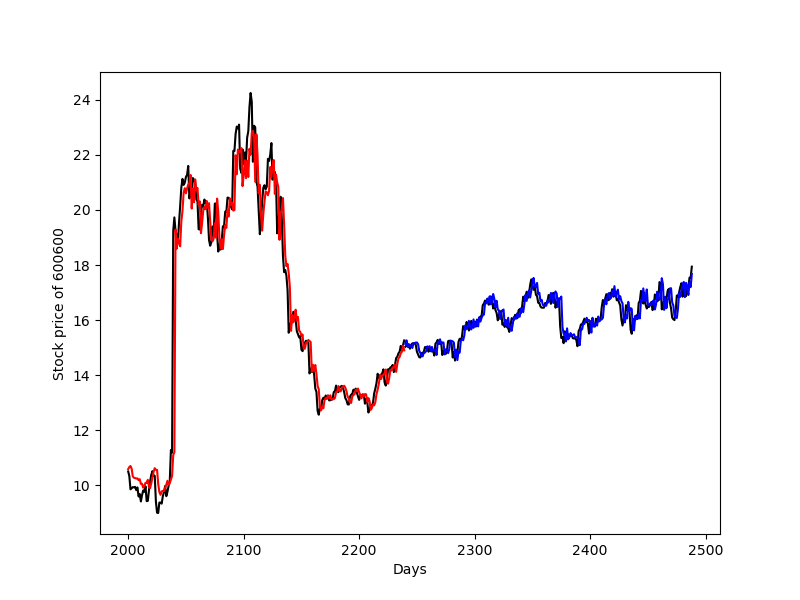

Evaluate the final accuracy using the following function, you can see that the accuracy in our best model gets to 99%, which means that most of them have a little difference from the real stock price.

In [137]:
driving = data
time_step = batch_size
target = t
dataset = Dataset(driving, target, time_step, split)
x_train = dataset.X[:dataset.train_size]
y_train = dataset.y[:dataset.train_size]
y_seq_train = dataset.y_seq[:dataset.train_size]
x_test = dataset.X[dataset.train_size:]
y_test = dataset.y[dataset.train_size:]
y_seq_test = dataset.y_seq[dataset.train_size:]   

y_pred_train = predict(x_train, y_train, y_seq_train, batch_size)
y_pred_test = predict(x_test, y_test, y_seq_test, batch_size)
predict_1 = y_pred_test

/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/chrisl

In [138]:
def get_error( scores , labels ):
    bs=len(scores)
    matches = 0.0    
    for i in range (len(scores)):
        if abs(scores[i] - labels[i]) <=1.5:
            matches+=1   
    return matches/bs

In [139]:
get_error(y_test , predict_1)

0.9959677419354839

# Analysis

Generally, we implemented a simple accuracy testing method which takes our prediction result and the ground truth test label as input. We has set a threshold 1.5,which means if the difference between any two close price pair is lower than 1.5 yuan, we count it as matched, By comparing and compute the difference between each price data pair, we got the accuracy 99% of making prediction of stock on ANN neural network. And by comparing and contrast with the foregoing 3 methods, ANN definitely shows its better performance on time sequential co-relationship data. 